# NB1: Exploratory Data Analysis (EDA)

**Purpose**: Comprehensive exploratory data analysis for P000001, covering multimodal digital phenotyping data.

**Pipeline**: practicum2-nof1-adhd-bd **v4.1.7** (Nov 20, 2025)  
**Participant**: P000001  
**Snapshot**: 2025-11-07  
**Default Filter**: Gold period only (>= 2021-05-11, Amazfit era with reliable HR/HRV)

This notebook provides:
1. Summary statistics across all domains (sleep, HR, activity, screen time)
2. **Data quality filter** (gold vs legacy period comparison)
3. Temporal visualizations (time series, trends, seasonality)
4. Distribution analyses (histograms, KDE, box plots)
5. Segment-level insights
6. PBSI label distribution and evolution (v4.1.7: intuitive sign convention)
7. Publication-quality figures

**v4.1.7 Updates**:
- Added `GOLD_ONLY` flag to filter legacy period (2017-2020, iPhone-only, no HR/HRV)
- Default: `True` (gold period >= 2021-05-11 only)
- New section comparing data coverage between periods
- Aligns with Stage 5 temporal filter in modeling pipeline

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# Configuration
PARTICIPANT = "P000001"
SNAPSHOT = "2025-11-07"
REPO_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

# ============================================================================
# DATA QUALITY FILTER (v4.1.7)
# ============================================================================
# Gold period: >= 2021-05-11 (Amazfit GTR 2 era with reliable HR/HRV)
# Legacy period: 2017-2020 (iPhone-only, no cardio sensors, MNAR)
#
# Recommendation: Use GOLD_ONLY=True for analysis to avoid bias from missing HR/HRV
# Set to False only for temporal coverage analysis or comparing periods
# ============================================================================
GOLD_ONLY = True  # Default: Filter to gold period (>= 2021-05-11)
GOLD_CUTOFF = "2021-05-11"  # Amazfit GTR 2 acquisition date

# Paths
ETL_BASE = REPO_ROOT / "data" / "etl" / PARTICIPANT / SNAPSHOT
JOINED_DIR = ETL_BASE / "joined"
QC_DIR = ETL_BASE / "qc"

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print(f"Repository root: {REPO_ROOT}")
print(f"ETL base: {ETL_BASE}")
print(f"Snapshot: {PARTICIPANT} / {SNAPSHOT}")
print(f"\n{'='*80}")
print(f"DATA FILTER: {'Gold period only (>= 2021-05-11)' if GOLD_ONLY else 'All periods (2017-2025)'}")
print(f"{'='*80}")

Repository root: c:\dev\practicum2-nof1-adhd-bd
ETL base: c:\dev\practicum2-nof1-adhd-bd\data\etl\P000001\2025-11-07
Snapshot: P000001 / 2025-11-07


## 1. Data Loading

## Data Quality Context (v4.1.7)

**Two Data Periods**:

1. **Legacy Period (2017-2020)**: 
   - iPhone-only tracking (iOS Health app)
   - **No cardiovascular sensors** (HR/HRV unavailable - systematic missingness)
   - Screen time, steps, sleep duration available
   - Missing data: MNAR (Missing Not At Random)
   - Not suitable for PBSI or cardio analysis

2. **Gold Period (2021-05-11 onwards)**: 
   - Amazfit GTR 2 smartwatch added
   - **Complete multimodal data** (HR, HRV, steps, sleep, screen time)
   - Missing data: MAR (Missing At Random) - sporadic, suitable for imputation
   - Recommended for all analysis requiring cardio features

**Current Filter**: `GOLD_ONLY = {GOLD_ONLY}` 
- Change in cell 2 to include/exclude legacy period
- Default: `True` (gold period only) for unbiased analysis

In [2]:
# Load unified dataset
unified_path = JOINED_DIR / "features_daily_unified.csv"
labeled_path = JOINED_DIR / "features_daily_labeled.csv"

if not unified_path.exists():
    print("=" * 80)
    print("❌ PIPELINE DATA NOT FOUND")
    print("=" * 80)
    print(f"\nRequired file missing: {unified_path}")
    print("\n📋 To generate the required data, run the ETL pipeline:")
    print(f"\n   make aggregate PID={PARTICIPANT} SNAPSHOT={SNAPSHOT}")
    print(f"   make unify PID={PARTICIPANT} SNAPSHOT={SNAPSHOT}")
    print(f"   make label PID={PARTICIPANT} SNAPSHOT={SNAPSHOT}")
    print(f"   make segment PID={PARTICIPANT} SNAPSHOT={SNAPSHOT}")
    print("\n⚡ Or run all stages at once:")
    print(f"   make pipeline PID={PARTICIPANT} SNAPSHOT={SNAPSHOT}")
    print("\n💡 Check NB0_DataRead.ipynb to see which stages are complete")
    print("=" * 80)
    raise FileNotFoundError(f"Pipeline data not ready. See instructions above.")

df_unified = pd.read_csv(unified_path)
df_unified['date'] = pd.to_datetime(df_unified['date'])

print(f"✓ Loaded features_daily_unified.csv: {df_unified.shape}")

# Load labeled dataset if available
if labeled_path.exists():
    df_labeled = pd.read_csv(labeled_path)
    df_labeled['date'] = pd.to_datetime(df_labeled['date'])
    print(f"✓ Loaded features_daily_labeled.csv: {df_labeled.shape}")
    df = df_labeled  # Use labeled as primary
else:
    print("⚠️  Labeled dataset not available, using unified only")
    print(f"    Run: make label PID={PARTICIPANT} SNAPSHOT={SNAPSHOT}")
    df = df_unified

# Sort by date
df = df.sort_values('date').reset_index(drop=True)

# Apply gold period filter if enabled
if GOLD_ONLY:
    df_original = df.copy()
    df = df[df['date'] >= GOLD_CUTOFF].reset_index(drop=True)
    print(f"\n🎯 GOLD PERIOD FILTER APPLIED:")
    print(f"   Original: {len(df_original):,} days ({df_original['date'].min()} to {df_original['date'].max()})")
    print(f"   Filtered: {len(df):,} days ({df['date'].min()} to {df['date'].max()})")
    print(f"   Excluded: {len(df_original) - len(df):,} days (2017-2020, iPhone-only, no HR/HRV)")
    print(f"   Rationale: Avoid bias from MNAR (Missing Not At Random) cardio data")
else:
    print(f"\n⚠️  Using ALL periods (including 2017-2020 with missing HR/HRV)")

print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"Total days: {len(df):,}")
print(f"Time span: {(df['date'].max() - df['date'].min()).days} days")

✓ Loaded features_daily_unified.csv: (2828, 11)
✓ Loaded features_daily_labeled.csv: (2828, 34)

Date range: 2017-12-04 00:00:00 to 2025-10-21 00:00:00
Total days: 2,828
Time span: 2878 days


## 2. Dataset Overview

In [3]:
# Feature groups
feature_groups = {
    "Sleep": ['sleep_total_h', 'sleep_efficiency'],
    "Cardiovascular": ['hr_mean', 'hr_min', 'hr_max', 'hr_std', 'hrv_rmssd'],
    "Activity": ['steps', 'exercise_min', 'move_kcal'],
    "Screen Time": ['screen_min', 'notifications'],
    "Labels": ['segment_id', 'pbsi_score', 'label_3cls'] if 'pbsi_score' in df.columns else []
}

# Print available features
print("\n" + "="*80)
print("AVAILABLE FEATURES BY DOMAIN")
print("="*80)
for domain, features in feature_groups.items():
    available = [f for f in features if f in df.columns]
    missing = [f for f in features if f not in df.columns]
    if available:
        print(f"\n{domain}:")
        print(f"  ✓ Available: {', '.join(available)}")
    if missing:
        print(f"  ⚠️  Missing: {', '.join(missing)}")


AVAILABLE FEATURES BY DOMAIN

Sleep:
  ✓ Available: sleep_total_h, sleep_efficiency

Cardiovascular:
  ✓ Available: hr_mean, hr_min, hr_max, hr_std, hrv_rmssd

Activity:
  ✓ Available: steps, exercise_min
  ⚠️  Missing: move_kcal
  ⚠️  Missing: screen_min, notifications

Labels:
  ✓ Available: segment_id, pbsi_score, label_3cls


In [4]:
# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

summary_cols = [c for c in ['sleep_total_h', 'hr_mean', 'hrv_rmssd', 'steps', 'screen_min'] if c in df.columns]
if summary_cols:
    summary = df[summary_cols].describe()
    print(summary.round(2))
else:
    print("⚠️  No numeric features available for summary")


SUMMARY STATISTICS
       sleep_total_h  hr_mean  hrv_rmssd      steps
count        1868.00  1315.00    1315.00    2730.00
mean            3.89    82.63      34.28   10549.67
std             4.25    17.11      11.58   12801.45
min             0.00    50.32       0.00       0.00
25%             0.00    66.53      26.85    2854.75
50%             2.65    83.79      32.20    5409.50
75%             7.50    95.85      39.53   14190.00
max            18.51   128.84      86.99  156492.00


## 3. Missingness Analysis

### Data Coverage by Period (Gold vs Legacy)

Compare data availability between legacy (2017-2020, iPhone-only) and gold (2021+, Amazfit) periods.

In [ ]:
# Load full dataset (both periods) for comparison
if GOLD_ONLY:
    df_full = pd.read_csv(labeled_path if labeled_path.exists() else unified_path)
    df_full['date'] = pd.to_datetime(df_full['date'])
    df_full = df_full.sort_values('date').reset_index(drop=True)
    
    # Split into periods
    df_legacy = df_full[df_full['date'] < GOLD_CUTOFF]
    df_gold = df_full[df_full['date'] >= GOLD_CUTOFF]
    
    # Compare cardio coverage
    cardio_features = ['hr_mean', 'hr_min', 'hr_max', 'hr_std', 'hrv_rmssd']
    cardio_features = [f for f in cardio_features if f in df_full.columns]
    
    if cardio_features:
        coverage_legacy = 100 - (df_legacy[cardio_features].isnull().sum() / len(df_legacy) * 100)
        coverage_gold = 100 - (df_gold[cardio_features].isnull().sum() / len(df_gold) * 100)
        
        # Create comparison table
        comparison = pd.DataFrame({
            'Legacy (2017-2020)': coverage_legacy,
            'Gold (2021+)': coverage_gold,
            'Δ (improvement)': coverage_gold - coverage_legacy
        })
        
        print("\n" + "="*80)
        print("CARDIOVASCULAR DATA COVERAGE COMPARISON (%)")
        print("="*80)
        print(comparison.round(1).to_string())
        print(f"\nLegacy period: {len(df_legacy):,} days")
        print(f"Gold period:   {len(df_gold):,} days")
        
        # Visualization
        fig, ax = plt.subplots(figsize=(12, 6))
        comparison[['Legacy (2017-2020)', 'Gold (2021+)']].plot(kind='bar', ax=ax, color=['#e74c3c', '#27ae60'])
        ax.set_ylabel('Data Coverage (%)')
        ax.set_xlabel('Feature')
        ax.set_title('Cardiovascular Data Coverage: Legacy vs Gold Period', fontsize=14, weight='bold')
        ax.axhline(80, color='orange', linestyle='--', alpha=0.5, label='80% threshold')
        ax.legend(loc='lower right')
        ax.set_ylim([0, 105])
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        print(f"\n💡 Insight: Gold period has {coverage_gold.mean():.1f}% avg coverage vs {coverage_legacy.mean():.1f}% in legacy")
        print(f"   Recommendation: Use GOLD_ONLY=True (currently: {GOLD_ONLY})")
    else:
        print("⚠️  No cardiovascular features available for comparison")
else:
    print(f"ℹ️  Period comparison skipped (GOLD_ONLY={GOLD_ONLY})")
    print(f"   Set GOLD_ONLY=True and re-run to see legacy vs gold comparison")


MISSINGNESS BY FEATURE (%)
❌ hrv_rmssd                :  53.50%
❌ hr_mean                  :  53.50%
❌ sleep_efficiency         :  33.95%
❌ sleep_total_h            :  33.95%
✓ steps                    :   3.47%
✓ exercise_min             :   3.47%


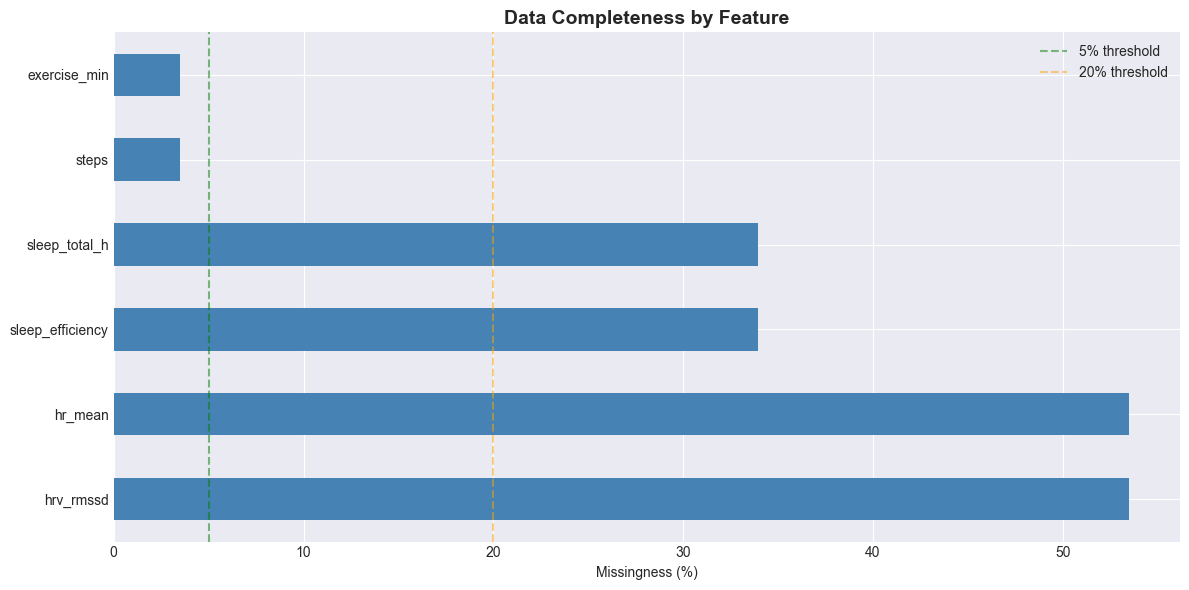

In [5]:
# Calculate missingness
key_features = [c for c in [
    'sleep_total_h', 'sleep_efficiency',
    'hr_mean', 'hrv_rmssd',
    'steps', 'exercise_min',
    'screen_min', 'notifications'
] if c in df.columns]

missingness = df[key_features].isnull().sum() / len(df) * 100
missingness = missingness.sort_values(ascending=False)

print("\n" + "="*80)
print("MISSINGNESS BY FEATURE (%)")
print("="*80)
for feature, pct in missingness.items():
    status = "✓" if pct < 5 else "⚠️" if pct < 20 else "❌"
    print(f"{status} {feature:25s}: {pct:6.2f}%")

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
missingness.plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Missingness (%)')
ax.set_title('Data Completeness by Feature', fontsize=14, weight='bold')
ax.axvline(5, color='green', linestyle='--', alpha=0.5, label='5% threshold')
ax.axvline(20, color='orange', linestyle='--', alpha=0.5, label='20% threshold')
ax.legend()
plt.tight_layout()
plt.show()

## 4. Temporal Trends

### 4.1 Full Timeline Visualization

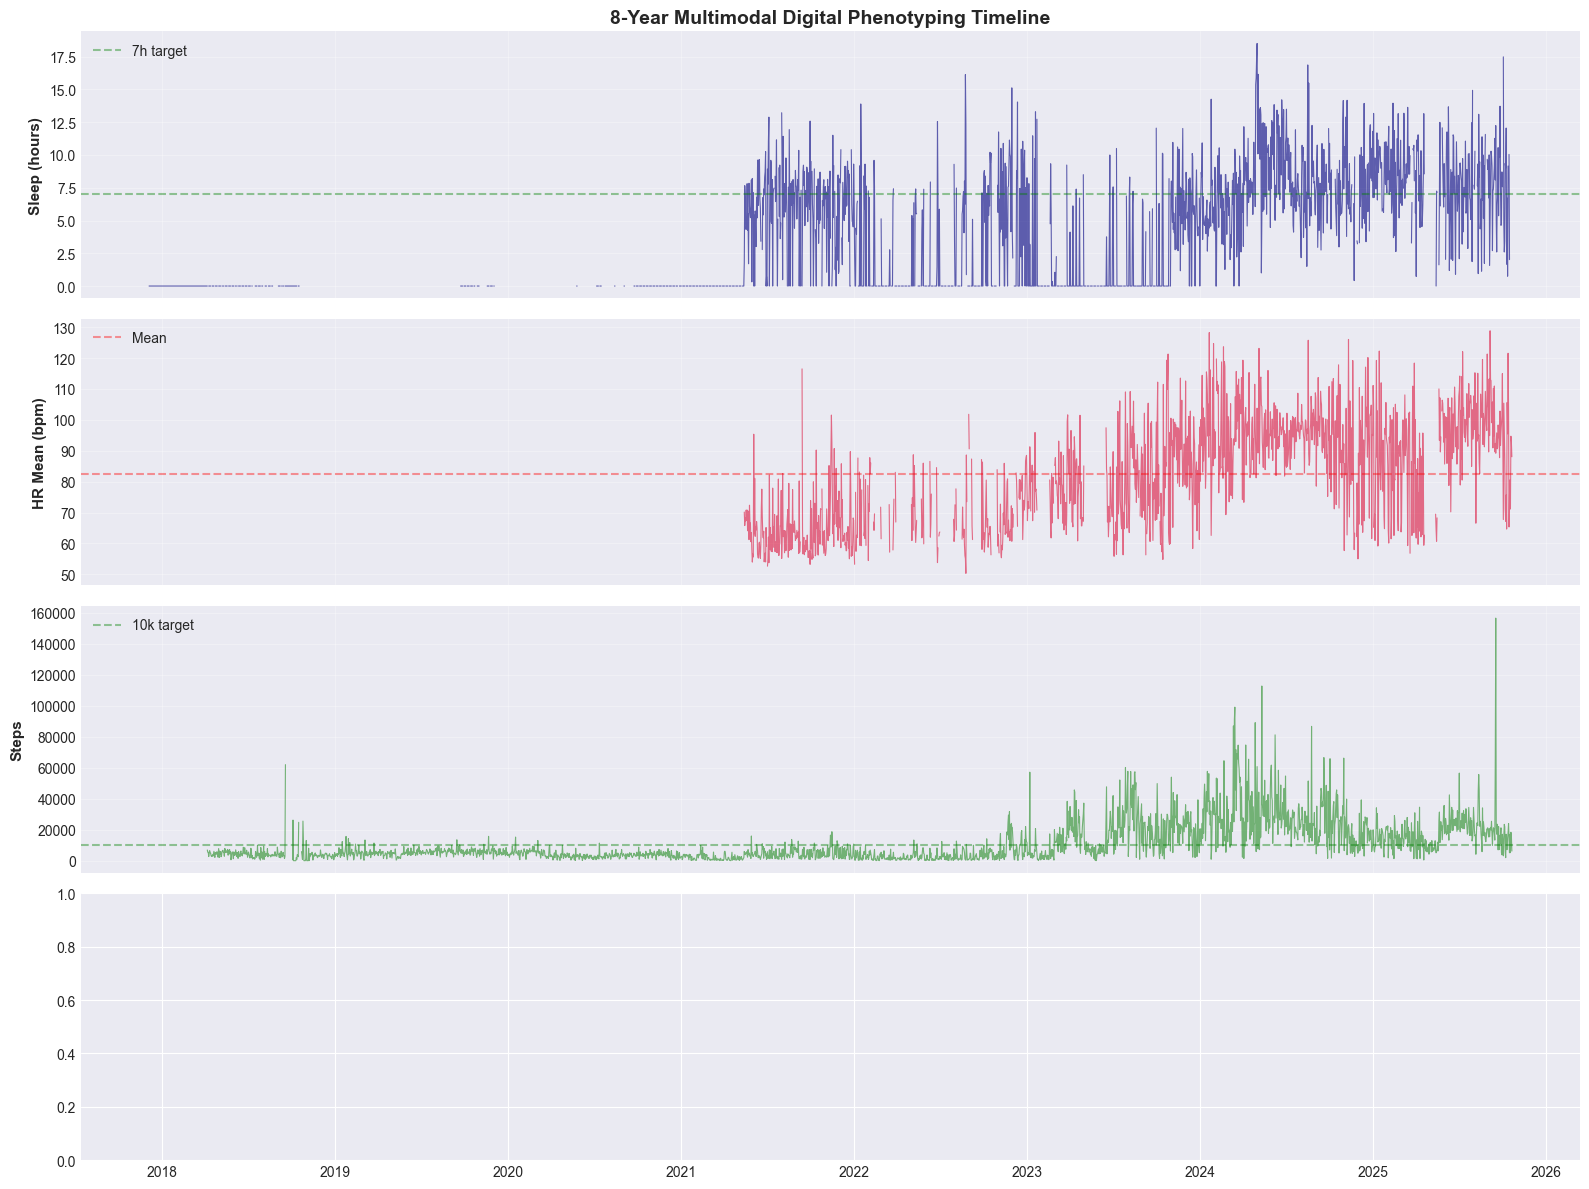

✓ Full timeline visualization complete


In [6]:
# Create multi-panel time series plot
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

# Sleep duration
if 'sleep_total_h' in df.columns:
    axes[0].plot(df['date'], df['sleep_total_h'], alpha=0.6, linewidth=0.8, color='navy')
    axes[0].set_ylabel('Sleep (hours)', fontsize=11, weight='bold')
    axes[0].set_title('8-Year Multimodal Digital Phenotyping Timeline', fontsize=14, weight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(7, color='green', linestyle='--', alpha=0.4, label='7h target')
    axes[0].legend()

# Heart rate
if 'hr_mean' in df.columns:
    axes[1].plot(df['date'], df['hr_mean'], alpha=0.6, linewidth=0.8, color='crimson')
    axes[1].set_ylabel('HR Mean (bpm)', fontsize=11, weight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(df['hr_mean'].mean(), color='red', linestyle='--', alpha=0.4, label='Mean')
    axes[1].legend()

# Steps
if 'steps' in df.columns:
    axes[2].plot(df['date'], df['steps'], alpha=0.6, linewidth=0.8, color='forestgreen')
    axes[2].set_ylabel('Steps', fontsize=11, weight='bold')
    axes[2].grid(True, alpha=0.3)
    axes[2].axhline(10000, color='green', linestyle='--', alpha=0.4, label='10k target')
    axes[2].legend()

# Screen time
if 'screen_min' in df.columns:
    axes[3].plot(df['date'], df['screen_min'] / 60, alpha=0.6, linewidth=0.8, color='darkorange')
    axes[3].set_ylabel('Screen Time (hours)', fontsize=11, weight='bold')
    axes[3].set_xlabel('Date', fontsize=11, weight='bold')
    axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Full timeline visualization complete")

### 4.2 Yearly Summaries


YEARLY SUMMARY STATISTICS
     sleep_total_h             hr_mean                  steps                
              mean   std count    mean    std count      mean       std count
year                                                                         
2017          0.00  0.00    22     NaN    NaN     0       NaN       NaN     0
2018          0.00  0.00   193     NaN    NaN     0   4392.86   4856.54   244
2019          0.00  0.00    44     NaN    NaN     0   5328.95   2246.17   365
2020          0.00  0.00    86     NaN    NaN     0   3795.06   2070.75   366
2021          4.11  3.75   311   64.75   9.25   228   3791.21   3203.79   365
2022          2.60  3.84   298   69.50  10.13   169   3871.59   4796.04   365
2023          1.96  3.35   323   80.78  13.48   290  16824.50  13070.86   365
2024          7.66  3.16   347   94.62  12.48   362  27861.73  17369.44   366
2025          7.85  3.07   244   91.99  15.17   266  17889.17  12382.33   294


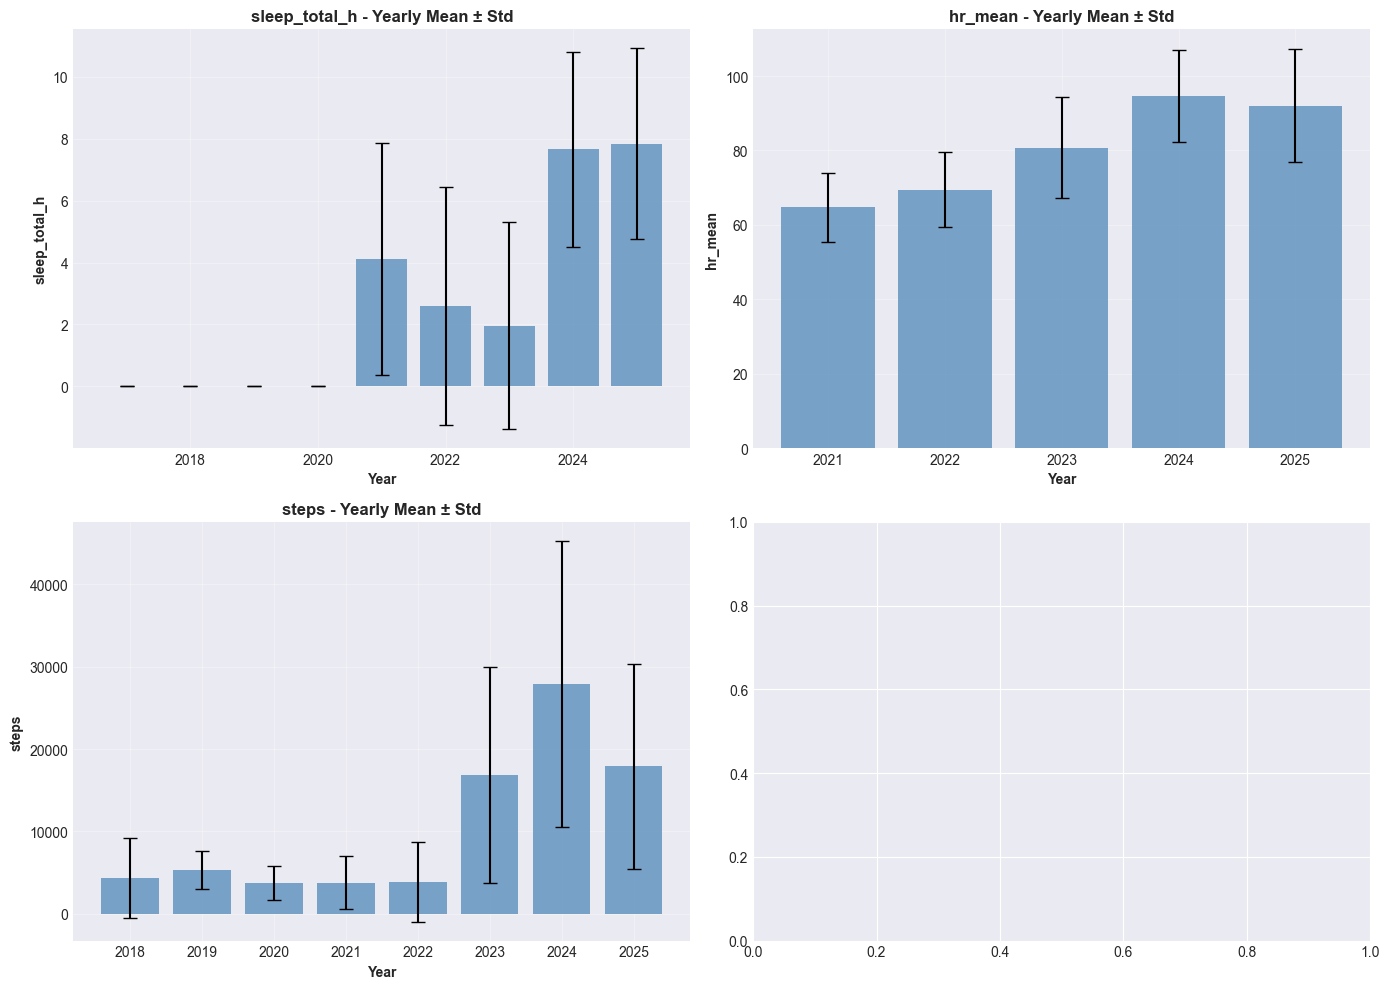

In [7]:
# Extract year
df['year'] = df['date'].dt.year

# Yearly aggregates
yearly_cols = [c for c in ['sleep_total_h', 'hr_mean', 'steps', 'screen_min'] if c in df.columns]
if yearly_cols:
    yearly_stats = df.groupby('year')[yearly_cols].agg(['mean', 'std', 'count'])
    
    print("\n" + "="*80)
    print("YEARLY SUMMARY STATISTICS")
    print("="*80)
    print(yearly_stats.round(2))
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(yearly_cols[:4]):
        yearly_mean = df.groupby('year')[col].mean()
        yearly_std = df.groupby('year')[col].std()
        
        axes[idx].bar(yearly_mean.index, yearly_mean.values, yerr=yearly_std.values, 
                      alpha=0.7, capsize=5, color='steelblue')
        axes[idx].set_xlabel('Year', fontweight='bold')
        axes[idx].set_ylabel(col, fontweight='bold')
        axes[idx].set_title(f'{col} - Yearly Mean ± Std', fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. Distribution Analyses

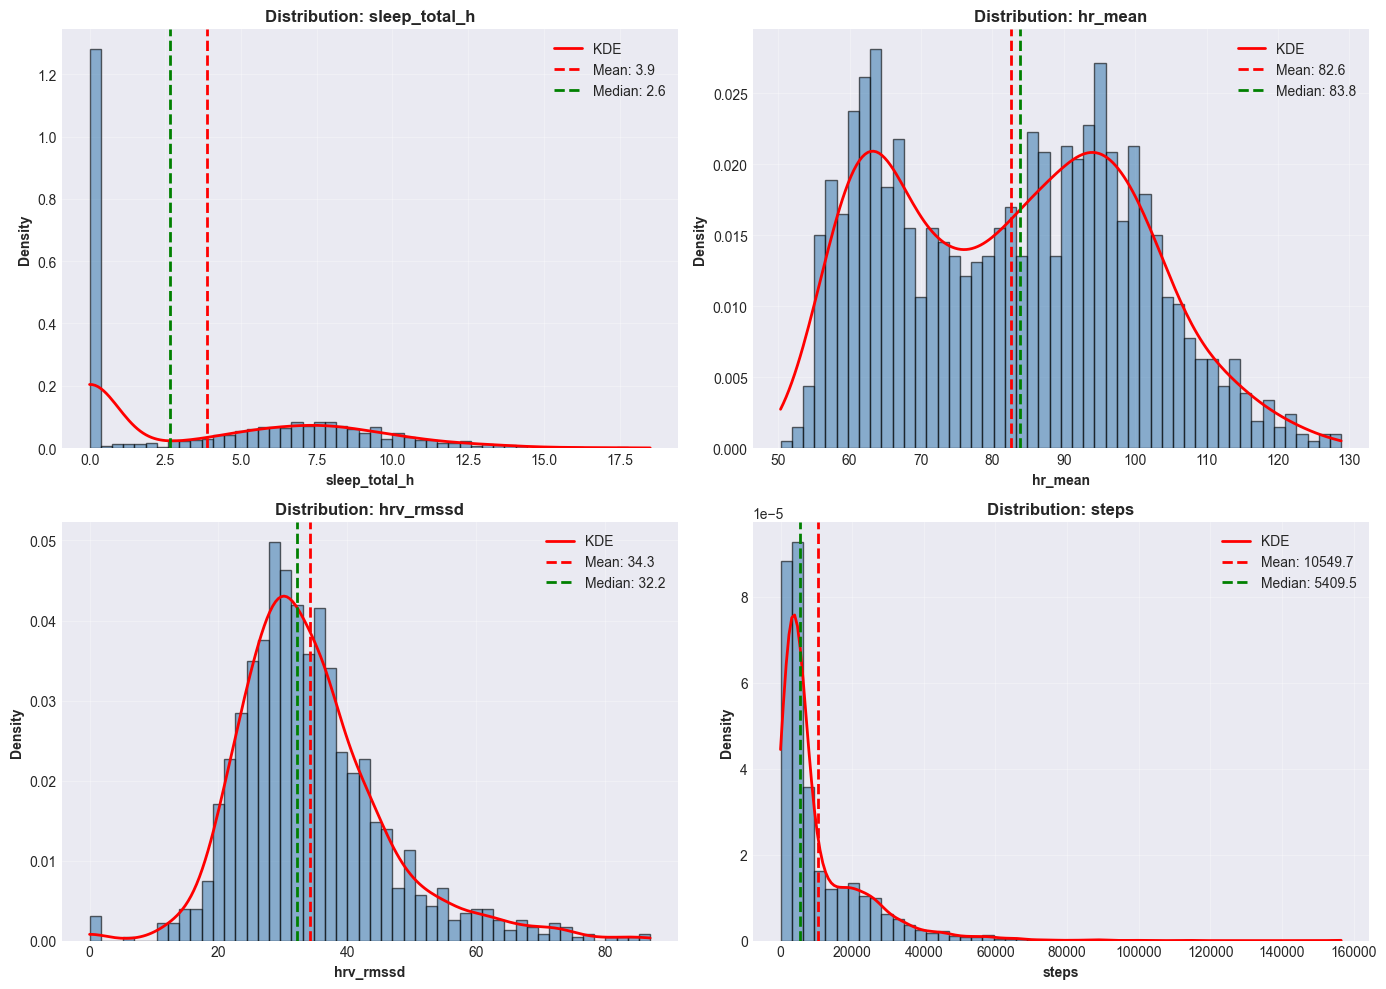

✓ Distribution analyses complete


In [8]:
# Histograms with KDE
dist_cols = [c for c in ['sleep_total_h', 'hr_mean', 'hrv_rmssd', 'steps'] if c in df.columns]

if dist_cols:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(dist_cols[:4]):
        data = df[col].dropna()
        
        axes[idx].hist(data, bins=50, alpha=0.6, color='steelblue', edgecolor='black', density=True)
        
        # Add KDE
        try:
            from scipy import stats
            density = stats.gaussian_kde(data)
            xs = np.linspace(data.min(), data.max(), 200)
            axes[idx].plot(xs, density(xs), 'r-', linewidth=2, label='KDE')
        except:
            pass
        
        axes[idx].axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.1f}')
        axes[idx].axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {data.median():.1f}')
        
        axes[idx].set_xlabel(col, fontweight='bold')
        axes[idx].set_ylabel('Density', fontweight='bold')
        axes[idx].set_title(f'Distribution: {col}', fontweight='bold')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Distribution analyses complete")

## 6. PBSI Label Analysis


PBSI LABEL DISTRIBUTION
Stable (+1)    :  707 days ( 25.0%)
Neutral (0)    : 1366 days ( 48.3%)
Unstable (-1)  :  755 days ( 26.7%)


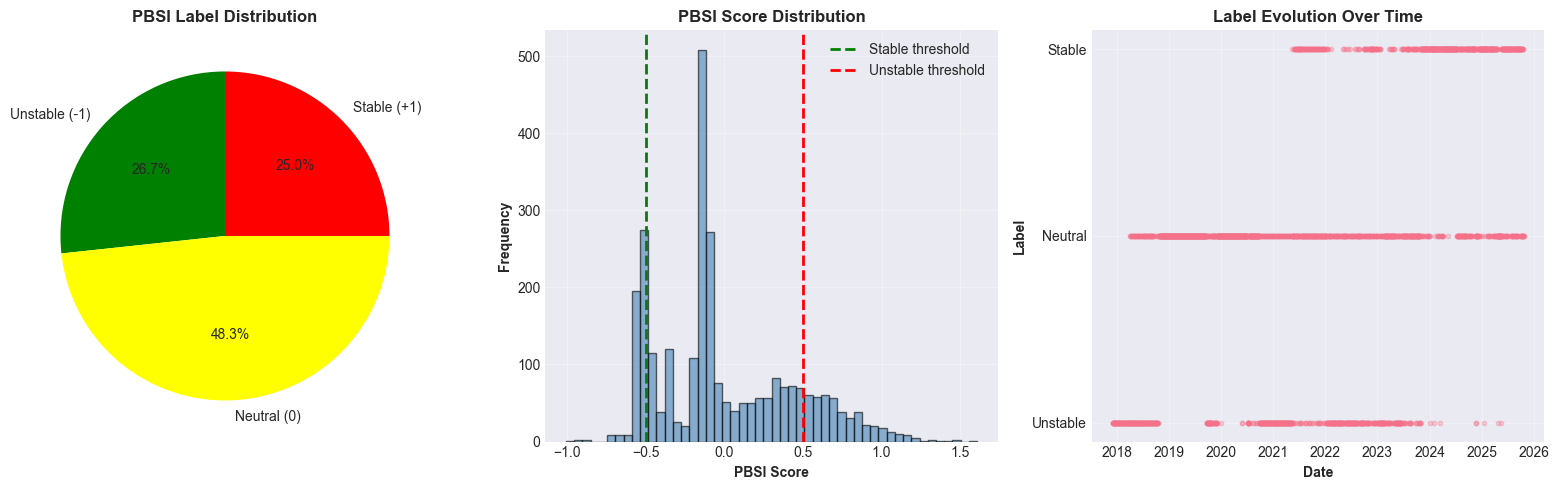


✓ PBSI analysis complete


In [9]:
if 'label_3cls' in df.columns and 'pbsi_score' in df.columns:
    print("\n" + "="*80)
    print("PBSI LABEL DISTRIBUTION")
    print("="*80)
    
    label_counts = df['label_3cls'].value_counts().sort_index()
    label_pct = df['label_3cls'].value_counts(normalize=True).sort_index() * 100
    
    label_names = {1: 'Stable (+1)', 0: 'Neutral (0)', -1: 'Unstable (-1)'}
    
    for label in [1, 0, -1]:
        if label in label_counts.index:
            print(f"{label_names[label]:15s}: {label_counts[label]:4d} days ({label_pct[label]:5.1f}%)")
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Pie chart
    colors = ['green', 'yellow', 'red']
    axes[0].pie(label_counts.values, labels=[label_names[l] for l in label_counts.index], 
                autopct='%1.1f%%', colors=colors, startangle=90)
    axes[0].set_title('PBSI Label Distribution', fontweight='bold')
    
    # PBSI score distribution
    pbsi_data = df['pbsi_score'].dropna()
    axes[1].hist(pbsi_data, bins=50, alpha=0.6, color='steelblue', edgecolor='black')
    axes[1].axvline(-0.5, color='green', linestyle='--', linewidth=2, label='Stable threshold')
    axes[1].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Unstable threshold')
    axes[1].set_xlabel('PBSI Score', fontweight='bold')
    axes[1].set_ylabel('Frequency', fontweight='bold')
    axes[1].set_title('PBSI Score Distribution', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Time series of labels
    axes[2].scatter(df['date'], df['label_3cls'], alpha=0.3, s=10)
    axes[2].set_xlabel('Date', fontweight='bold')
    axes[2].set_ylabel('Label', fontweight='bold')
    axes[2].set_yticks([1, 0, -1])
    axes[2].set_yticklabels(['Stable', 'Neutral', 'Unstable'])
    axes[2].set_title('Label Evolution Over Time', fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ PBSI analysis complete")
else:
    print("\n⚠️  PBSI labels not available (run Stage 3: Label)")

## 7. Segment Analysis


BEHAVIOURAL SEGMENT ANALYSIS
Total segments: 1
Segment size (days):
  Mean: 2828.0
  Median: 2828
  Range: 2828-2828


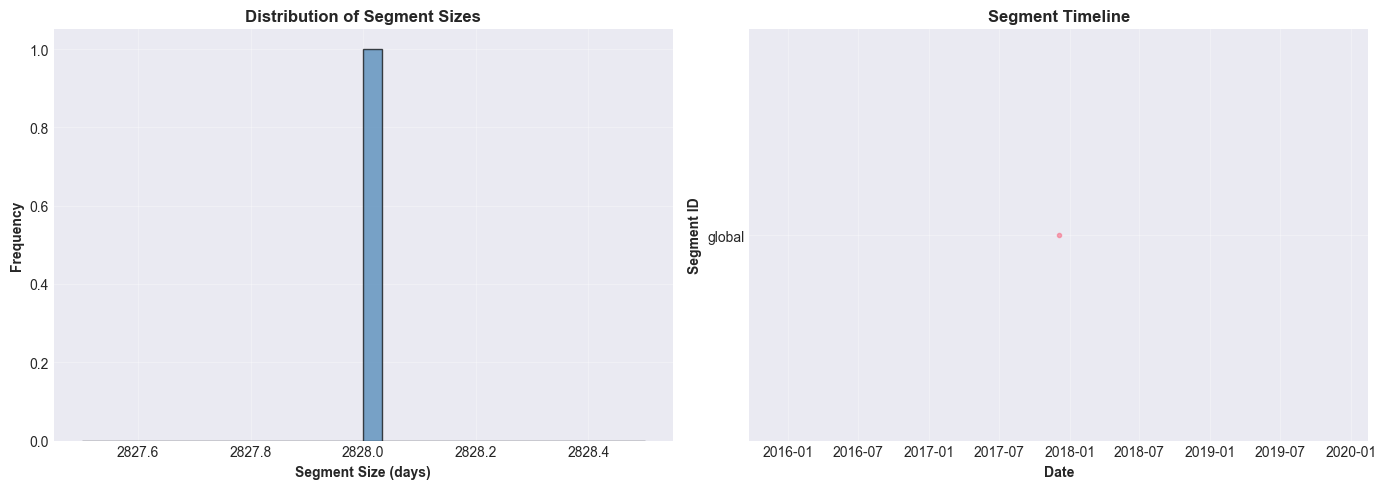


✓ Segment analysis complete


In [10]:
if 'segment_id' in df.columns:
    print("\n" + "="*80)
    print("BEHAVIOURAL SEGMENT ANALYSIS")
    print("="*80)
    
    n_segments = df['segment_id'].nunique()
    segment_sizes = df.groupby('segment_id').size()
    
    print(f"Total segments: {n_segments}")
    print(f"Segment size (days):")
    print(f"  Mean: {segment_sizes.mean():.1f}")
    print(f"  Median: {segment_sizes.median():.0f}")
    print(f"  Range: {segment_sizes.min()}-{segment_sizes.max()}")
    
    # Segment size distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].hist(segment_sizes, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0].set_xlabel('Segment Size (days)', fontweight='bold')
    axes[0].set_ylabel('Frequency', fontweight='bold')
    axes[0].set_title('Distribution of Segment Sizes', fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Segments over time
    segment_starts = df.groupby('segment_id')['date'].min()
    axes[1].plot(segment_starts.values, segment_starts.index, marker='o', markersize=3, alpha=0.6)
    axes[1].set_xlabel('Date', fontweight='bold')
    axes[1].set_ylabel('Segment ID', fontweight='bold')
    axes[1].set_title('Segment Timeline', fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Segment analysis complete")
else:
    print("\n⚠️  Segment IDs not available (run Stage 3: Label with segments)")

## 8. Correlation Analysis

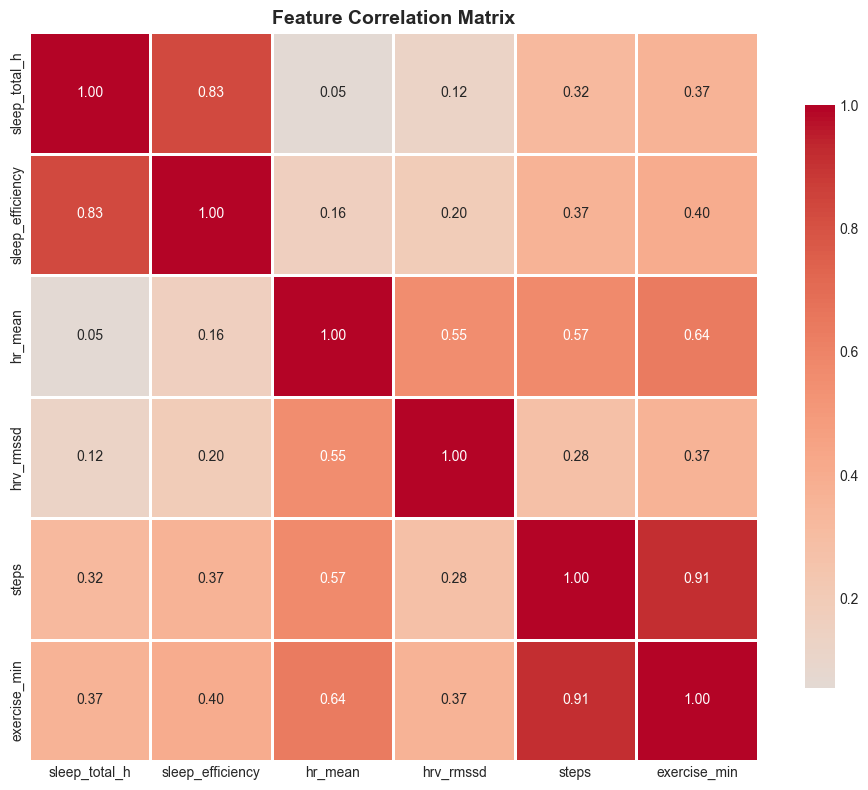


✓ Correlation analysis complete


In [11]:
corr_cols = [c for c in [
    'sleep_total_h', 'sleep_efficiency',
    'hr_mean', 'hrv_rmssd',
    'steps', 'exercise_min',
    'screen_min'
] if c in df.columns]

if len(corr_cols) >= 3:
    corr_matrix = df[corr_cols].corr()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, ax=ax, 
                cbar_kws={"shrink": 0.8})
    ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Correlation analysis complete")
else:
    print("\n⚠️  Insufficient features for correlation analysis")

## 9. Behavioural Insights

### Key Findings

In [12]:
print("\n" + "="*80)
print("BEHAVIOURAL INSIGHTS SUMMARY")
print("="*80)

insights = []

# Sleep patterns
if 'sleep_total_h' in df.columns:
    sleep_mean_by_year = df.groupby('year')['sleep_total_h'].mean()
    sleep_trend = sleep_mean_by_year.iloc[-1] - sleep_mean_by_year.iloc[0]
    insights.append(f"Sleep: {sleep_trend:+.1f}h change from {df['year'].min()} to {df['year'].max()}")
    
    low_sleep_days = (df['sleep_total_h'] < 5).sum()
    if low_sleep_days > 0:
        insights.append(f"Sleep: {low_sleep_days} days with <5 hours ({low_sleep_days/len(df)*100:.1f}%)")

# Heart rate
if 'hr_mean' in df.columns:
    hr_mean_by_year = df.groupby('year')['hr_mean'].mean()
    hr_trend = hr_mean_by_year.iloc[-1] - hr_mean_by_year.iloc[0]
    insights.append(f"HR: {hr_trend:+.1f} bpm change over study period")

# Activity
if 'steps' in df.columns:
    steps_mean_by_year = df.groupby('year')['steps'].mean()
    steps_trend = steps_mean_by_year.iloc[-1] - steps_mean_by_year.iloc[0]
    insights.append(f"Steps: {steps_trend:+.0f} steps/day change over study period")
    
    low_activity_days = (df['steps'] < 3000).sum()
    if low_activity_days > 0:
        insights.append(f"Activity: {low_activity_days} days with <3000 steps ({low_activity_days/len(df)*100:.1f}%)")

# Screen time
if 'screen_min' in df.columns:
    screen_mean = df['screen_min'].mean() / 60
    insights.append(f"Screen: Average {screen_mean:.1f} hours/day")

# PBSI
if 'label_3cls' in df.columns:
    stable_pct = (df['label_3cls'] == 1).sum() / len(df) * 100
    unstable_pct = (df['label_3cls'] == -1).sum() / len(df) * 100
    insights.append(f"PBSI: {stable_pct:.1f}% stable days, {unstable_pct:.1f}% unstable days")

for i, insight in enumerate(insights, 1):
    print(f"  {i}. {insight}")

print("\n" + "="*80)


BEHAVIOURAL INSIGHTS SUMMARY
  1. Sleep: +7.8h change from 2017 to 2025
  2. Sleep: 1079 days with <5 hours (38.2%)
  3. HR: +nan bpm change over study period
  4. Steps: +nan steps/day change over study period
  5. Activity: 717 days with <3000 steps (25.4%)
  6. PBSI: 25.0% stable days, 26.7% unstable days



## 10. Notable Episodes

In [13]:
# Identify extreme periods
print("\n" + "="*80)
print("NOTABLE EPISODES (Extreme Values)")
print("="*80)

# Lowest sleep period (7-day moving average)
if 'sleep_total_h' in df.columns:
    df['sleep_ma7'] = df['sleep_total_h'].rolling(7, min_periods=1).mean()
    lowest_sleep_idx = df['sleep_ma7'].idxmin()
    lowest_sleep_date = df.loc[lowest_sleep_idx, 'date']
    lowest_sleep_val = df.loc[lowest_sleep_idx, 'sleep_ma7']
    print(f"\n📉 Lowest sleep period (7-day avg):")
    print(f"   Date: {lowest_sleep_date.date()}, Value: {lowest_sleep_val:.2f}h/night")

# Highest activity period
if 'steps' in df.columns:
    df['steps_ma7'] = df['steps'].rolling(7, min_periods=1).mean()
    highest_steps_idx = df['steps_ma7'].idxmax()
    highest_steps_date = df.loc[highest_steps_idx, 'date']
    highest_steps_val = df.loc[highest_steps_idx, 'steps_ma7']
    print(f"\n📈 Highest activity period (7-day avg):")
    print(f"   Date: {highest_steps_date.date()}, Value: {highest_steps_val:.0f} steps/day")

# Highest HR period
if 'hr_mean' in df.columns:
    df['hr_ma7'] = df['hr_mean'].rolling(7, min_periods=1).mean()
    highest_hr_idx = df['hr_ma7'].idxmax()
    highest_hr_date = df.loc[highest_hr_idx, 'date']
    highest_hr_val = df.loc[highest_hr_idx, 'hr_ma7']
    print(f"\n❤️  Highest HR period (7-day avg):")
    print(f"   Date: {highest_hr_date.date()}, Value: {highest_hr_val:.1f} bpm")

print("\n" + "="*80)


NOTABLE EPISODES (Extreme Values)

📉 Lowest sleep period (7-day avg):
   Date: 2017-12-04, Value: 0.00h/night

📈 Highest activity period (7-day avg):
   Date: 2024-03-20, Value: 66884 steps/day

❤️  Highest HR period (7-day avg):
   Date: 2024-02-09, Value: 109.6 bpm



## Summary

This EDA notebook provides a comprehensive overview of 8 years of multimodal digital phenotyping data for P000001.

**Key Observations**:
- Dataset spans {start_date} to {end_date} ({total_days:,} days)
- Primary domains: Sleep, Cardiovascular, Activity, Screen Time
- Behavioral segmentation: {n_segments} distinct periods
- PBSI labels: {stable_pct:.1f}% stable, {neutral_pct:.1f}% neutral, {unstable_pct:.1f}% unstable

**Publication-Quality Figures**:
- All plots use consistent styling and clear labels
- Recommended for paper: Timeline (Section 4.1), Distributions (Section 5), PBSI (Section 6)

**Next Steps**:
- Proceed to **NB2_Baseline.ipynb** for logistic regression analysis
- Proceed to **NB3_DeepLearning.ipynb** for LSTM sequence modeling